# **Retention Modeling and Analysis**

- Which factors or combination of factors best predict an employer's likelihood to retain(i.e. renewed flag = 1) ? And how well does your chosen model predict retention? Please list any assumptions you made in the modeling process and explain why you chose yoour methodolgy.

- Based on your analysis what modification would you recommend we make to our ad platform algorithm to improve retention?

In [ ]:
#Mounting colab to read the data from google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
from plotly.subplots import make_subplots
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from collections import Counter
# instantiating the random oversampler 
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import plotly.graph_objs as go
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Reding excel files
data_1 = pd.read_excel("/content/drive/MyDrive/Data.xlsx", \
                       sheet_name='Ex 1 - slot_performance Table')
data_2 = pd.read_excel("/content/drive/MyDrive/Data.xlsx", \
                       sheet_name='Ex 2 - location Table')

### **Structure of the dataset**

We merged both the dataset to perform an overall analysis on the basis of all the factors that are important for Glassdoor in terms of clients.

We observe the following structure of the dataset:

Dimensions of slot performance table: (37757, 12)\
Dimensions of location table: (11458, 4)\
Number of records in the merged dataframe: 37757\
Number of fields in each record in the merged dataframe: 15\
Name of the columns: 'employer_id', 'city_id', 'contract_id', 'start_date', 'end_date',
       'renewed_flag', 'job_slots', 'total_contract_value', 'applications',
       'apply_start_clicks', 'click_marketplace_value', 'job_listings',
       'city_name', 'state_id', 'state_name'

In [ ]:
print("Dimensions of slot performance table:", data_1.shape)
print("Dimensions of location table:", data_2.shape)

#Merging both the datasets to get a combined dataframe
data = pd.merge(data_1, data_2)

#Structure of the new combined dataset
dim = data.shape
print("Number of records in the merged dataframe:", dim[0])
print("Number of fields in each record in the merged dataframe:", dim[1])
print(data.columns)
data.head()


Dimensions of slot performance table: (37757, 12)
Dimensions of location table: (11458, 4)
Number of records in the merged dataframe: 37757
Number of fields in each record in the merged dataframe: 15
Index(['employer_id', 'city_id', 'contract_id', 'start_date', 'end_date',
       'renewed_flag', 'job_slots', 'total_contract_value', 'applications',
       'apply_start_clicks', 'click_marketplace_value', 'job_listings',
       'city_name', 'state_id', 'state_name'],
      dtype='object')


,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,city_name,state_id,state_name
0,4.277920e+06,9767,2423796,2017-10-30,2017-11-30 23:59:59,1,15,995,215,255,15484.4,25,Kaser,NY,New York
1,1.747093e+06,9767,2123400,2017-07-19,2017-08-18 23:59:59,1,15,1745,20,145,3131.2,0,Kaser,NY,New York
2,2.833227e+06,9767,1895796,2017-04-22,2017-05-21 23:59:59,1,15,495,80,120,726.2,20,Kaser,NY,New York
3,1.827813e+06,9767,1283400,2016-08-03,2016-09-02 23:59:59,1,15,495,20,45,1852.1,0,Kaser,NY,New York
4,2.234880e+06,9767,2021376,2017-06-12,2017-07-11 23:59:59,1,15,745,85,95,2339.5,0,Kaser,NY,New York


### **Checking null values in the dataset**

We can observe that the dayaset is clean with no null values.

In [ ]:
#Checking null values in the data
data.isnull().sum()

employer_id                0
city_id                    0
contract_id                0
start_date                 0
end_date                   0
renewed_flag               0
job_slots                  0
total_contract_value       0
applications               0
apply_start_clicks         0
click_marketplace_value    0
job_listings               0
city_name                  0
state_id                   0
state_name                 0
dtype: int64

In [ ]:
#description of dataset
data.describe()

,employer_id,city_id,contract_id,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings
count,3.775700e+04,37757.000000,3.775700e+04,37757.000000,37757.000000,37757.000000,37757.000000,37757.000000,37757.000000,37757.000000
mean,3.401370e+06,5715.522632,2.004281e+06,0.703393,16.902164,1027.530921,47.396509,97.144900,2519.346427,3.600657
std,1.565622e+06,3307.261011,4.983748e+05,0.456768,7.934682,522.671477,129.527538,228.824005,5227.354775,8.928060
min,9.525333e+04,1.000000,1.037544e+06,0.000000,15.000000,110.000000,0.000000,0.000000,0.000000,0.000000
25%,2.177600e+06,2873.000000,1.586892e+06,0.000000,15.000000,495.000000,0.000000,0.000000,97.850000,0.000000
50%,3.156320e+06,5711.000000,2.002524e+06,1.000000,15.000000,995.000000,10.000000,35.000000,1139.150000,0.000000
75%,4.425760e+06,8552.000000,2.408832e+06,1.000000,15.000000,1495.000000,50.000000,110.000000,2907.450000,5.000000
max,7.756080e+06,11458.000000,2.925240e+06,1.000000,50.000000,5990.000000,6080.000000,12770.000000,356440.000000,350.000000


In [ ]:
#Count of unique values in the categorical features
summarystats_categorical_feat = []
categorical_feature = [feature for feature in data.columns if data[feature].dtype == 'O']
summarystats_categorical_feat = [[feature, len(data[feature].unique())] for feature in categorical_feature]
df = pd.DataFrame(summarystats_categorical_feat, columns=["Features", "Unique Categories"])
df

,Features,Unique Categories
0,city_name,8909
1,state_id,10
2,state_name,10


From obove table, we can observe that only 3 variables are categorical and all others are numerical.

Next I wanted to check the correlation between the features of our dataset. From the below mentioned correlation matrix we can say that:

- our renewed flag(target variable) is only slightly correlated with all features. 
- The highest correlation we can observed with renewed_flag is with 'click_market_value' feature.
- We can also observe high correlation between job_slots,total_contract_value ,applications, apply_start_clicks, click_marketplace_value,job_listings.

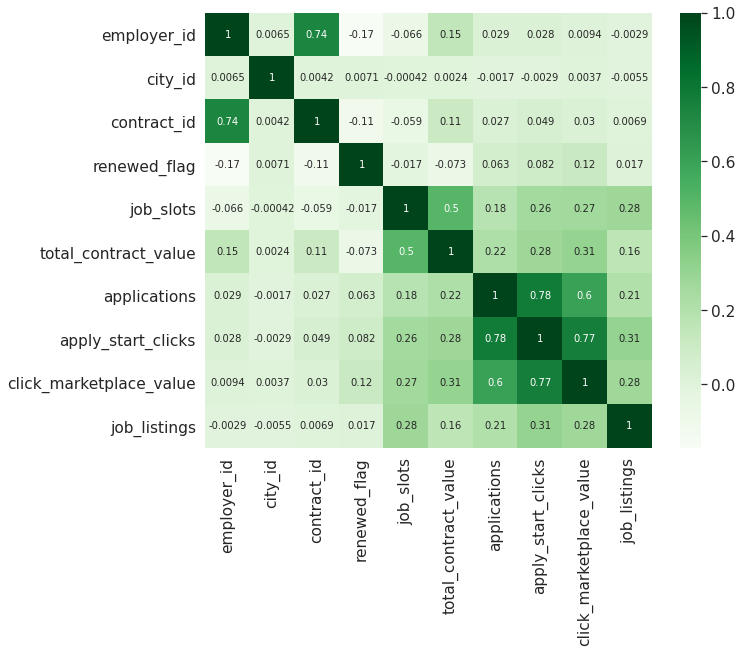

In [ ]:
#Finding correlation between the variables
plt.figure(figsize=(10,8))
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True,cmap ='Greens')
plt.show()

## **Data Analysis and Feature Engineering**

Data Analysis is very important for understanding the hidden structures in the data and understanding what factor affects the target variable and how they affect. Once we have analyzed the data it is good to modify the features as per requirement to perform better modeling.

### **Feature: End date and start date**

Creating a new column named contract duration to check how long the contract existed.

In [ ]:
data['contract_duration'] = (data['end_date'] - data['start_date']).dt.days.astype(float)


### **Feature: renewed_flag**

This is our target variable. We want to check the distribution of our target variable so that further modifications could be made in the dataset. 

**Observations:** We can obser that only 26558 (70.3 %) contracts were renewed and 11199 (29.7 %) contracts were not renewed. 

In [ ]:
#dividing data into two dataframes on the basis of renewed flag for further analysis
nt_renew_data = data[data.renewed_flag == 0]
renew_data = data[data.renewed_flag == 1]

#count of our target labels
print("Clients who did not renewed the subscription:" , data[data.renewed_flag == 0].shape)
print("Clients who renewed the subscription:" , data[data.renewed_flag == 1].shape)

Clients who did not renewed the subscription: (11199, 16)
Clients who renewed the subscription: (26558, 16)


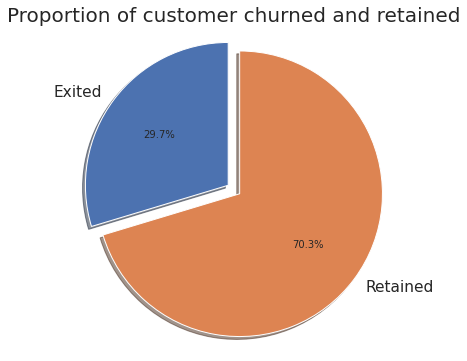

In [ ]:
labels = 'Exited', 'Retained'
sizes = [data.renewed_flag[data['renewed_flag']==0].count(), \
         data.renewed_flag[data['renewed_flag']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

In [ ]:
data.job_slots.unique()

array([15, 50])

**Feature: job_slots**

**Observation:** From the below plot we can observe that customers have only 2 job slots and most of the customers preferred 15 job slots contract. We can observe that we have almost double the number of customers who renewed the subscription for both 15 and 50 job_slots.

[15 50]


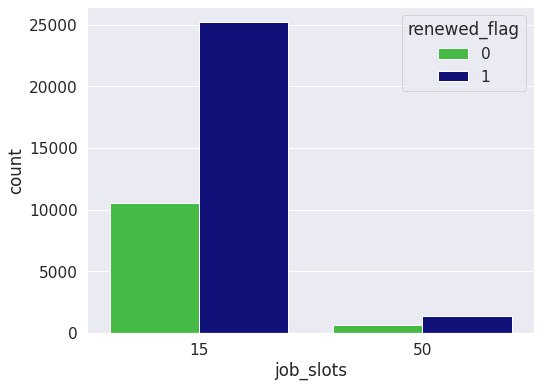

In [ ]:
print(data.job_slots.unique())
plt.figure(figsize=(8, 6))
sns.countplot(x='job_slots', hue = 'renewed_flag',data = data, \
              palette=['limegreen', 'darkblue'])

**Feature: state_id**

**Observation:** We can observe from the below plot that we have customers from 10 states and we have almost double the number of customers that renewed the subscription as compared to customers who did not renew. Top 5 participating customer states are Pensylvania, texas, california, Illinois and Ohio. 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

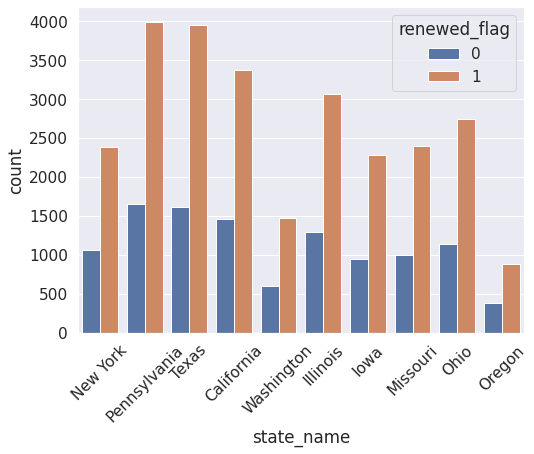

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='state_name', hue = 'renewed_flag',data = data)
plt.xticks( rotation=45)

**Feature: Job_listing**

**Observation**

- From the boxplot we can say that 75 % of both the type of customers have posted 15 jobs.
- Many of the renewed and exited customers have 0 job_listings.
- We have few exited customers with more job listings as compared to renewed customers



In [ ]:
import plotly.graph_objs as go
fig = make_subplots(rows=4, cols=1)

tr1=go.Box(x=renew_data['job_listings'],name='Boxplot_renewed',boxmean=True)
tr2=go.Histogram(x=renew_data['job_listings'],name='Histogram_renewed')
tr3=go.Box(x=nt_renew_data['job_listings'],name='Boxplot_exited',boxmean=True)
tr4=go.Histogram(x=nt_renew_data['job_listings'],name='Histogram_exited')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)
fig.add_trace(tr3,row=3,col=1)
fig.add_trace(tr4,row=4,col=1)
fig.update_layout(height=600, width=700, \
                  title_text="Distribution of job listing for renewed and exited customers")
fig.show()


**Feature : Applications**

**Observations:** 

- We can observe that 75% of the applications renewed customers recieved were under 150 whereas existed customers recieved under 85 application which is a very less number.
- Existed customer have even recieved maximum of 6080 applications as compared to renewed customers with 2960 application as maximum.
- We still have more than 5000 exited customers with zero application and more than 10000 renewed customers with zero applications which needs to be investigated

In [ ]:
fig = make_subplots(rows=4, cols=1)

tr1=go.Box(x=renew_data['applications'],name='Boxplot_renewed',boxmean=True)
tr2=go.Histogram(x=renew_data['applications'],name='Histogram_renewed')
tr3=go.Box(x=nt_renew_data['applications'],name='Boxplot_exited',boxmean=True)
tr4=go.Histogram(x=nt_renew_data['applications'],name='Histogram_exited')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)
fig.add_trace(tr3,row=3,col=1)
fig.add_trace(tr4,row=4,col=1)
fig.update_layout(height=600, width=700, \
                  title_text="Distribution of applications for renewed and exited customers")
fig.show()

**Feature: apply_start_clicks**

**Observations:**

- From the boxplots we can observe that we have few customers in exited box plot who have recieved more than 5k apply_start_clicks as compare to renewed plot. 
- We can still observe that a lot of customers are gettting zero apply_start_clicks i.e. not getting attention from job seekers properly.
- 75% of customers are getting 0 to 350 apply_start_clicks in the cases of retained customerd and 0 to 215 in case of exited customer which is in the lower side.


In [ ]:
fig = make_subplots(rows=4, cols=1)

tr1=go.Box(x=renew_data['apply_start_clicks'],name='Boxplot_renewed',boxmean=True)
tr2=go.Histogram(x=renew_data['apply_start_clicks'],name='Histogram_renewed')
tr3=go.Box(x=nt_renew_data['apply_start_clicks'],name='Boxplot_exited',boxmean=True)
tr4=go.Histogram(x=nt_renew_data['apply_start_clicks'],name='Histogram_exited')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)
fig.add_trace(tr3,row=3,col=1)
fig.add_trace(tr4,row=4,col=1)
fig.update_layout(height=600, width=700, \
                  title_text="Distribution of apply_start_clicks for renewed and exited customers")
fig.show()

**Feature: total Contract Value:**

**Observations:** We can make following observations from the below boxplot and histogram:

- min and max Total contract value for renewd and exited customers is very near with max being the same.
- We can observe that higher number of customers newed the contract as compared to exited customers.
- Mean for both the type of customers in distribution is very near.
- We have one contract as outlier in bother the cases with max value 5990 $

In [ ]:
fig = make_subplots(rows=4, cols=1)

tr1=go.Box(x=renew_data['total_contract_value'],name= "Boxplot_renewed", boxmean=True)
tr2=go.Histogram(x=renew_data['total_contract_value'],name= "Histogram_renewed")
tr3=go.Box(x=nt_renew_data['total_contract_value'],name= "Boxplot_exited",boxmean=True)
tr4=go.Histogram(x=nt_renew_data['total_contract_value'],name= "Histogram_renewed")

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)
fig.add_trace(tr3,row=3,col=1)
fig.add_trace(tr4,row=4,col=1)
fig.update_layout(height=600, width=700, \
                  title_text="Distribution of total contract value for renewed and exited customers")
fig.show()

**Feature: Click_marketplace_value:**

**Observations:** We can make following observations from the below boxplot and histogram:
- From the box plots we can say that we have a distribution of customers with zero Click_marketplace_value to thousands of dollar as the maximum click market place value achieved with max being 356.44 k in case of renewed customers and 112.35k in case of exited customers. This is a very big gap among the two type of customers due to outliers.
- The interQuartile range seems similar for both the type of customers.
- We have a lot of customers in both the categories who are getting zero or very minimal 'click_marketplace_value' which could be investigated for finding the reason and we can make changes accordingly to retain more customers.

In [ ]:
import plotly.graph_objs as go
fig = make_subplots(rows=4, cols=1)

tr1=go.Box(x=renew_data['click_marketplace_value'],name="Boxplot_renewed",boxmean=True)
tr2=go.Histogram(x=renew_data['click_marketplace_value'],name= "Histogram_renewed")
tr3=go.Box(x=nt_renew_data['click_marketplace_value'],name= "Boxplot_exited",boxmean=True)
tr4=go.Histogram(x=nt_renew_data['click_marketplace_value'],name= "Histogram_renewed")

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)
fig.add_trace(tr3,row=3,col=1)
fig.add_trace(tr4,row=4,col=1)
fig.update_layout(height=600, width=700, \
                  title_text="Distribution of Click Marketplace value for renewed and exited customers")
fig.show()

**Conclusions from above plots**:

From the above observation of the individual features we can say that even though our both the type of customers are paying similar total contract value and exited customers are getting higher number of apply start clicks and they are getting lesser 'applications' and lesser 'click_marketplace_value' which could be one of the reasons of not renewing the contract.

Also we need to analyze further the how zero applications, apply_start_clicks, click_marketplace_value and job listing affect the Job_slots subscription. To analysis this I am performing detailed analysis on not renewed cutomers.


In [ ]:
#checking if there are any exited client with zero applications, apply_start_clicks, click_marketplace_value and no job listing
data_with_zeroes = data[(data.applications == 0) & (data.apply_start_clicks == 0) \
 & (data.click_marketplace_value == 0) & (data.renewed_flag == 0) & (data.job_listings == 0)]
data_with_zeroes.shape

(1906, 16)

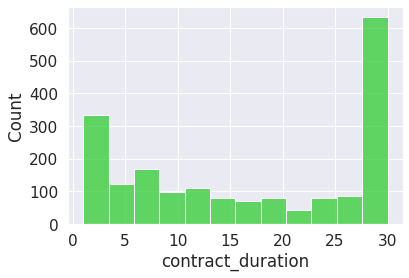

In [ ]:
#Check for how long these customer stayed in contract
sns.histplot(x='contract_duration', data = data_with_zeroes, color= 'limegreen')

**Observations**:

In the above section, I got 1906 contracts with zero applications, apply_start_clicks, click_marketplace_value and no job listings. I then checked the contract duration for those customers. We can observe that either most customers have left the subscription in the initial days or did not use the subscription properly as we have around 650 customer who did post job listing for 30 days.

Further I wanted to check if we have customers who stayed in the contract for a months and have job listings also.

In [ ]:
#Checking how many customer utilized the whole one month duration
data_month = nt_renew_data[(nt_renew_data.contract_duration >28) & (nt_renew_data.job_listings > 0)]
data_month.shape

(1269, 16)

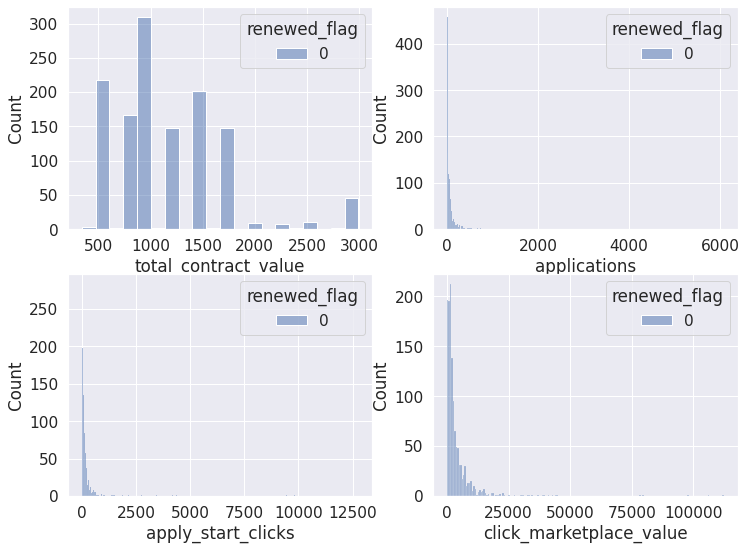

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 9))
sns.histplot(x='total_contract_value', hue = 'renewed_flag',data = data_month,ax=axarr[0][0])
sns.histplot(x='applications', hue = 'renewed_flag',data = data_month, ax=axarr[0][1])
sns.histplot(x='apply_start_clicks', hue = 'renewed_flag',data = data_month, ax=axarr[1][0])
sns.histplot(x='click_marketplace_value', hue = 'renewed_flag',data = data_month, ax=axarr[1][1])

**Observations**:

For the customers who used the platform for 29 days and above and have posted the job listings, many customers still recieved 0 applications, 0 apply start clicks and click_market_place value. This implies we have customers who used the platform for more than 28 days and posted jobs, they didnt get any attention from job seekers. We can further check the type of customers, domain, location and how relevant those job listings are with respect to the jobseekers.


Next I analyzed the performance of the job_slots in terms of applications vs cost-per-applications. I found the cost per application dividing total_contract_value/total number of applications.

For this I have removed rows with 0 applications because we will have infinite cost_per_application for those contract_ids.

In [ ]:
#Calculating cost_per_application 
data_cpa = data[data.applications > 0]
data_cpa['cost_per_application'] =  (data_cpa['total_contract_value']/(data_cpa['applications']).astype(float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_cpa_nRenew = data_cpa[data_cpa.renewed_flag == 0]
data_cpa_Renew = data_cpa[data_cpa.renewed_flag == 1]

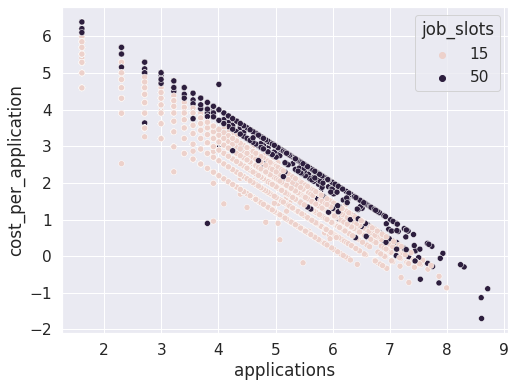

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=data_cpa, x=np.log(data_cpa['applications']), \
                y=np.log(data_cpa['cost_per_application']), hue="job_slots")

#as we increase the job_slots the performance is more for 15 jobslots

**Observation:** 

Since we calculated cost-per-application from application being inversely related. We can say our performance is high if our cost-per-application is low which is logical.
 
I further created a correlation matrix to check how the features vary with cost-per-applications.

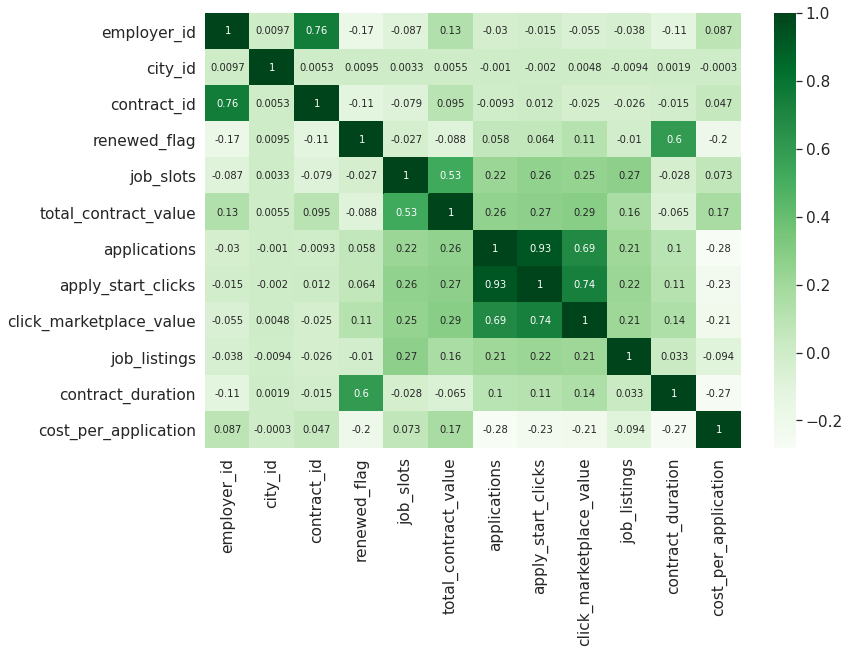

In [ ]:
#Finding correlation between the variables
plt.figure(figsize=(12,8))
corrMatrix = data_cpa.corr()
sns.heatmap(corrMatrix, annot=True,cmap ='Greens')
plt.show()

**Obseravtions:**

- From the above correlation matrix, we can say that our performance is high if we have more number of 'job listings' and 'applications'. Performance is also directly proportional to 'apply_start_clicks' and 'click_marketplace_value'. 

- Performance is inversly proportional 'total_contract_value' and 'job_slots'.



## **Modeling**

This is a classic 2 class classification problem with 'renew_flag being' the target variable.

For modeling I am dropping few features with hight number of uniques values which are not significant such as 'employer_id','city_id','contract_id','start_date', 'end_date','city_name','state_id'. I have also replaced the start date and end date with contract duration.

In [ ]:
data_cpa = data_cpa.drop(['employer_id','city_id','contract_id', \
                          'start_date', 'end_date','city_name','state_id'],axis = 1)

In [ ]:
data_cpa.head()

,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,state_name,contract_duration,cost_per_application
0,1,15,995,215,255,15484.4,25,New York,31.0,4.627907
1,1,15,1745,20,145,3131.2,0,New York,30.0,87.250000
2,1,15,495,80,120,726.2,20,New York,29.0,6.187500
3,1,15,495,20,45,1852.1,0,New York,30.0,24.750000
4,1,15,745,85,95,2339.5,0,New York,29.0,8.764706


### Label Encoding using Label Encoder()

This done to make the categorical variable continou. Here we have state_name which is categorical.

In [ ]:

labelencoder = LabelEncoder()
data_cpa['state_name']= labelencoder.fit_transform(data_cpa['state_name']) 
data_cpa.head()

,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,state_name,contract_duration,cost_per_application
0,1,15,995,215,255,15484.4,25,4,31.0,4.627907
1,1,15,1745,20,145,3131.2,0,4,30.0,87.250000
2,1,15,495,80,120,726.2,20,4,29.0,6.187500
3,1,15,495,20,45,1852.1,0,4,30.0,24.750000
4,1,15,745,85,95,2339.5,0,4,29.0,8.764706


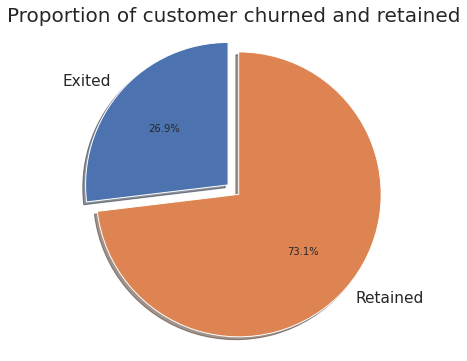

In [ ]:
labels = 'Exited', 'Retained'
sizes = [data_cpa.renewed_flag[data_cpa['renewed_flag']==0].count(), \
         data_cpa.renewed_flag[data_cpa['renewed_flag']==1].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

We can still observe from above plot that we have unbalanced data.

### **Dataset Splitting**

It is important to split the dataset into training data and testing data so as to hide the some datapoints while training the model and checking the model performance on the hidden(test data) for observing near real-time performance. I took a classic 80:20 % train:test ratio for train-test splitting.

In [ ]:
y = data_cpa.loc[:,'renewed_flag']
data_cpa = data_cpa.drop(['renewed_flag'], axis = 1)
X = data_cpa
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify= y, \
                                                  test_size=0.20, random_state=42)
print(X_train.shape,y_train.shape)
print(X_val.shape, y_val.shape)
X_train = X_train.reset_index(drop =True)
y_train = y_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

**Classification: Baseline Models**

I am using two standard baseline models to observe the model performance with the unbalanced dataset. Our aim is the predict the retention rate for the models:

1. Logistic Regression
2. Random Forest

I have chosen logistic regression and random forest because, logistic regression is the most basic classification model applicable. Randon forest is a advance model which can handle data imbalance well thus taking randome forest too as a baseline model.


In [ ]:
# fit a logistic regression model to the data
def logisticRegression(train_x, train_y,test_x, test_y):
  model = LogisticRegression(max_iter = 100, random_state= 42)
  model.fit(train_x, train_y)
  print(model)
  # make predictions
  expected = test_y
  predicted = model.predict(test_x)
  # summarize the fit of the model
  print(classification_report(expected, predicted))
  print(confusion_matrix(expected, predicted))
  disp = plot_confusion_matrix(model, test_x, test_y,
                                 cmap=plt.cm.Blues,normalize = 'true')
  disp.ax_.set_title("Confusion Matrix")
  plt.figure(figsize=(10,6))
  sns.set(font_scale=1.4)
  print("Confusion Matrix")
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.83      0.37      0.51      1196
           1       0.81      0.97      0.88      3251

    accuracy                           0.81      4447
   macro avg       0.82      0.67      0.69      4447
weighted avg       0.81      0.81      0.78      4447

[[ 437  759]
 [  92 3159]]
Confusion Matrix


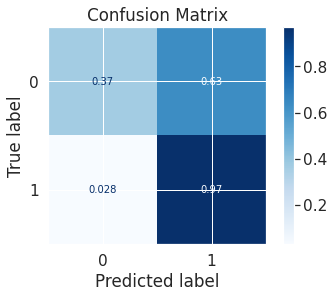

<Figure size 720x432 with 0 Axes>

None


In [ ]:
print(logisticRegression(X_train, y_train, X_val, y_val)) 

In [ ]:
def randomForest(train_x, train_y,test_x, test_y):
  clf = RandomForestClassifier(n_estimators = 6, max_depth =40, random_state=0)
  clf.fit(train_x,train_y)
  print(classification_report(test_y, clf.predict(test_x)))
  print(confusion_matrix(test_y, clf.predict(test_x)))
  disp = plot_confusion_matrix(clf, test_x, test_y,
                                 cmap=plt.cm.Blues, normalize = 'true')
  disp.ax_.set_title("Confusion Matrix")
  print("Confusion Matrix")
  plt.show()

              precision    recall  f1-score   support

           0       0.76      0.68      0.71      1196
           1       0.89      0.92      0.90      3251

    accuracy                           0.85      4447
   macro avg       0.82      0.80      0.81      4447
weighted avg       0.85      0.85      0.85      4447

[[ 811  385]
 [ 262 2989]]
Confusion Matrix


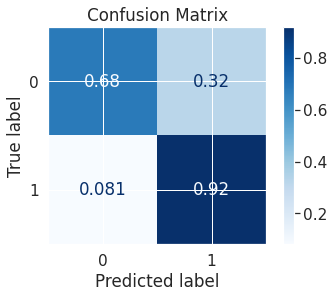

None


In [ ]:
print(randomForest(X_train, y_train, X_val, y_val))


**performance metric:** We will use recall and f1 score as a performance metric here because it is imbalanced class model so, if we use accuracy as a performance metric, accuracy could be biased towards the majority class whereas recall will give right performance for both class.

**Observations:**

- Logistic Regression: From the confustion matrix of logistic regression, we can say that we are getting a very high true postive rate (97 %) but we also have a high False positive rate (63 %) and a very low true negative rate (37 %). Our aim should be to decrease false positive and increase true negative.

- Random Forest: We are getting much better results using random forest. We were able to decrese false positiive and increase true negatives. Our true positive rate slightly decreased with random forest.

We can further check better models, so I am also going to check with adaboost classifier. Boosting algorithms combine multiple low accuracy models to create a high accuracy model. AdaBoost is example of Boosting algorithm. The important advantages of AdaBoost Low generalization error, easy to implement, works with a wide range of classifiers, no parameters to adjust. Especial attention is needed to data as this algorithm is sensitive to outliers.

In [ ]:
def AdaBoost(X_train,y_train,X_val,y_val):
  classifier = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=1),
      n_estimators=200
  )
  classifier.fit(X_train, y_train)

  predictions = classifier.predict(X_val)
  print(classification_report(y_val, predictions))
  print(confusion_matrix(y_val, predictions))
  disp = plot_confusion_matrix(classifier, X_val, y_val,
                                  cmap=plt.cm.Blues, normalize = 'true')
  disp.ax_.set_title("Confusion Matrix")
  print("Confusion Matrix")
  plt.show()


              precision    recall  f1-score   support

           0       0.92      0.61      0.73      1196
           1       0.87      0.98      0.92      3251

    accuracy                           0.88      4447
   macro avg       0.90      0.79      0.83      4447
weighted avg       0.88      0.88      0.87      4447

[[ 729  467]
 [  64 3187]]
Confusion Matrix


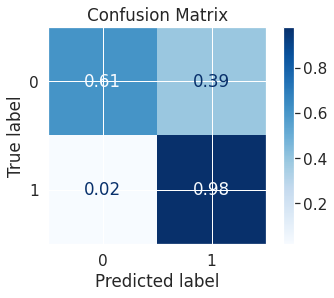

In [ ]:
AdaBoost(X_train, y_train, X_val, y_val)

**Observation:**

Adaboost gave a comparitively high true positive rate but increased the false positive rate too.


**Oversampling:**

We can further try oversampling technique to handle the data imbalance. I am using SMOTE for oversampling. SMOTE(Synthetic Minority Oversampling Technique) is the most widely used approach to synthesizing new examples. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. Synthetic over-sampling works to cause the classifier to build larger decision regions that contain nearby minority class points.


In [ ]:

X_resampled, y_resampled = SMOTE().fit_sample(X, y)
counter = Counter(y_resampled)
print(counter)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, \
                                                  stratify= y_resampled, \
                                                  test_size=0.20, random_state=42, \
                                                  shuffle = True)
print(X_train.shape,y_train.shape)
print(X_val.shape, y_val.shape)
# X_train = X_train.reset_index(drop =True)
# y_train = y_train.reset_index(drop = True)
# X_val = X_val.reset_index(drop = True)
# y_val = y_val.reset_index(drop = True)

Counter({1: 16251, 0: 16251})
(26001, 9) (26001,)
(6501, 9) (6501,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3251
           1       0.89      0.90      0.90      3250

    accuracy                           0.89      6501
   macro avg       0.89      0.89      0.89      6501
weighted avg       0.89      0.89      0.89      6501

[[2877  374]
 [ 312 2938]]
Confusion Matrix


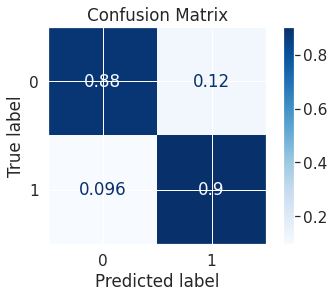

None


In [ ]:
print(randomForest(X_train, y_train, X_val, y_val))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      3251
           1       0.86      0.98      0.92      3250

    accuracy                           0.91      6501
   macro avg       0.92      0.91      0.91      6501
weighted avg       0.92      0.91      0.91      6501

[[2746  505]
 [  62 3188]]
Confusion Matrix


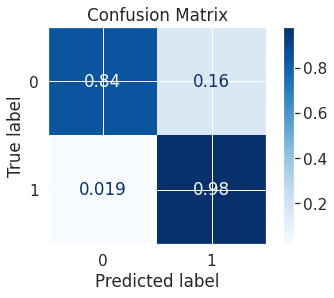

In [ ]:
AdaBoost(X_train, y_train, X_val, y_val)

**Observation:**

- With oversampling using SMOTE we can observe good results for both Random Forest and AdaBoost. We were able to decrese False positive to a very low value and also increase True negative to high value with high True positive which is very good for retention analysis prediction model. 

- We can choose Adaboost since our priority is higher true positives that is high retention model.

# Modifications and Recommendations:

- From the above analysis we can see that many of our customers did not use the platform properly since they did not post any jobs and paid they paid 'total_contract_value' for the contract. Since we have observed the performance is inversely proportional to both the job_listings and total_contract_value, we can create a job_listing tracker for customers and reach out to customers who are not posting jobs. In this way we'll be able to give personalized recommendations to customers for improvements and also increase retention.

- We can also provide better promotional offers to customers who are willing to leave after one contract to retain them.

- We can create a tracker which can track the ratio of job listings to the number of application since the cost_per_application is inversely proportional to performance so we can track the performance for those customers and analyze why is this happening and what other factors are responsible for higher cost-per-application.

- We can further study why some customers are getting low click_marketplace_value even which high apply_start_clicks and applications as click_marketplace_value is directly proportional to performance would help in increasing retention.

In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Glassdoor.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/Glassdoor.ipynb to pdf
/usr/local/lib/python2.7/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) [u'text/html'] is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in Glassdoor_files/
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_files
[NbConvertApp] Making directory ./Glassdoor_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'